## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, we will employ several supervised algorithms of our choice to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000.  

In [2]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = np.sum(data['income'] == '>50K')

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = np.sum(data['income'] == '<=50K')

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = 100 * (n_greater_50k/(n_greater_50k+n_at_most_50k))

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 


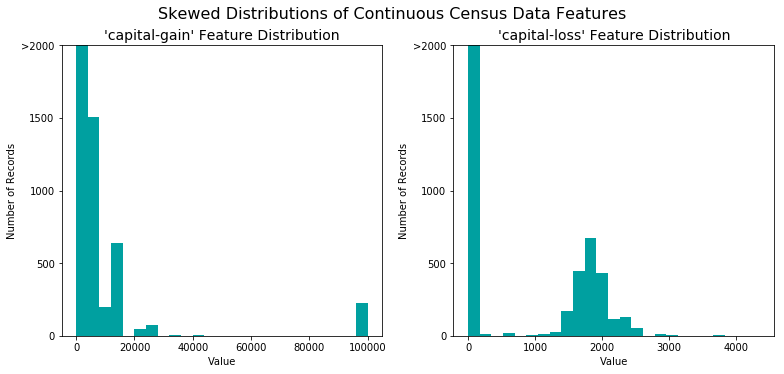

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.


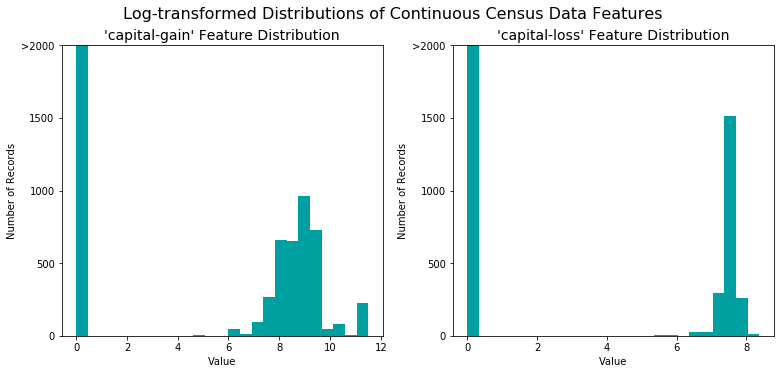

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.


In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. 

In [6]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
#non_numerical = ['workclass','education_level','marital-status','occupation','relationship','race','sex','native-country']
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = (income_raw == '>50K')
income = income.astype(dtype = int)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print(encoded)


103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

###  Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.
 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [8]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# TODO: Calculate accuracy, precision and recall
income_pred = np.ones(shape=income.shape)
accuracy = accuracy_score(income,income_pred)
precision = precision_score(income,income_pred)
recall = recall_score(income,income_pred)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta=0.5
fscore = ((1+beta*beta)*(precision*recall))/((beta*beta*precision)+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Model Application
* Which supervised learning modelis suitable for sucha task ?

# Answer:

## Ensemble Methods(AdaBoost):

- Real-world application: AdaBoost is a technique of fitting weak learners repeatedly on the data , finally to get an overall better classifier. Adaboost algorithm is used commercially where a the data is rich. One such example of AdaBoost algorithm is face-detection. The adaboost algorithm using weak learners can identify certain features of the pixels of the image and detect if that particular area is the face or the background of the image.
- Strengths: The main strength of AdaBoost is that it has very less hyper parameters to tune(namely 'base_estimator', 'n_estimator' and 'learning_rate'. Due to this the AdaBoost algorithm is pretty fast as compared to other algorithms like neural networks and SVM.
- Weakness: AdaBoost algorithm is highly affected by the quality of data that we are working with. If our data has quite some number of outliers, then such outliers would affect the performance of the adaboos classifier
- Why a good Candidate: Our dataset is large but we have cleaned it to quite some extent, and as a result I think that using the adaboost algorithm with decision stump would be quick in training and would also generate good results on the test data

## Stochastic Gradient Descent Classifier (SGDC):

- Real-world application: A perceptron classifier is an example of SGDC family of classifiers. A perceptron algorithm is used as a binary classifier when the data is linearly separable. When there are more than 2 classes to classify we can still use the perceptron classifier to classify this multi-class data through the use of one vs rest or the one vs one classification technique. Commercially Perceptron algorithm is generally used in classification task such as a good or a bad review, ratings of a book depending on certain features etc.
- Strengths: The theory of Perceptron algorithm states that if the data is linearly seperable the algorithm will find a decision boundary that will always separate the clusters of data points. SGDC algorithms are quite fast as compared to other algorithms. 
- Weakness: Even if the data is linearly separable, but if our learning rate is too small, the gradient descent will take very small leaps towards the global minimum and the algorithm will take a very long time to converge i.e to find a decision boundry. On the other hand if the data is not linearly separable and we keep running the perceptron algorithm , it will never converge and will keep on going indefinitely. In such a case we will have to specify the maximum number of iterations after which the perceptron algorithm should stop. Also needless to say the main drawback of SGDC algorithms like perceptron is that it is inherently a linear classifier and when it comes across a non-linear data it will perform very poorly and in such a circumstance we should use non-linear or probabilistic classifiers SVM, Neural networks or Naive Bayes respectively.
- Why a good Candidate: Being a binary classification problem we can think of a perceptron algorithm to classify the data well by finding a linear decision boundary, obviously considering that the data is linearly separable.

## SVM:

- Real-world application: SVM are a class of algorithms that work on the principle of Langrange optimization. A simple SVM with a linear kernel is a linear classifier, however as we change the kernel from linear to polynomial with n degrees or rbf, the SVM classifier becomes a nonlinear classifier. SVM algorithms are used in a plethora of applications but is most commonly used for text and hyper-text categorization(For example: Classification of news articles as "sports" or "science", or classification of web-pages as personal or others, or to find potential clients for a long term deposit account at a bank depending on various features like salary, loans, education etc.  
- Strengths: An SVM algorithm with a non-linear kernel almost always performs better or atleast the same than its linear counter-parts and also the linear SGDC algorithms. of the There are two main strengths SVM algorithm and they are as follows:
    - The SVM algorithm decides its spearating boundry by maximizing the separating boundary between the points closest to the boundary(These points are also known as the support vectors). Due to the fact that the SVM algorithm considers only a few points(support vectors) from the vast numbers of possible data points to generate its decision boundary, the algorithm works very well and provides good results even when the amount of data available is less. Thus SVM algorithm works well with less data.
    - Due to the kernel trick the limitation of linear classifiers is overcome as we can now model SVM as a non-linear classifier. And this makes sense because the data that we see in the real world is almost never linearly spearable and during such a time a nonliner classifier like SVM comes in handy and gives better results as compared to its linear counter-parts.
- Weakness: The SVM algorithm has the following weaknesses:
    - When the data set is large the SVM algorithm takes a conclusively longer time than other algorithms like SGDC or AdaBoost with decision trees.
    - Also if we are not careful in tuning the hyper-parameters or even the parameters SVM tends to overfit the data when the data is highly overlapping.
- Why a good Candidate: Since this is a classification problem with only two class, a nonliner SVM with properly tuned hyper parameters may perform well on the classification.

        

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Our implementation here will be used in the following section.


In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[0:sample_size],y_train[0:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[0:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[0:sample_size],predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[0:sample_size],predictions_train,0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:

**Note:** Depending on which algorithms we chose, the following implementation may take some time to run!

AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
SGDClassifier trained on 361 samples.
SGDClassifier trained on 3617 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier trained on 36177 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.


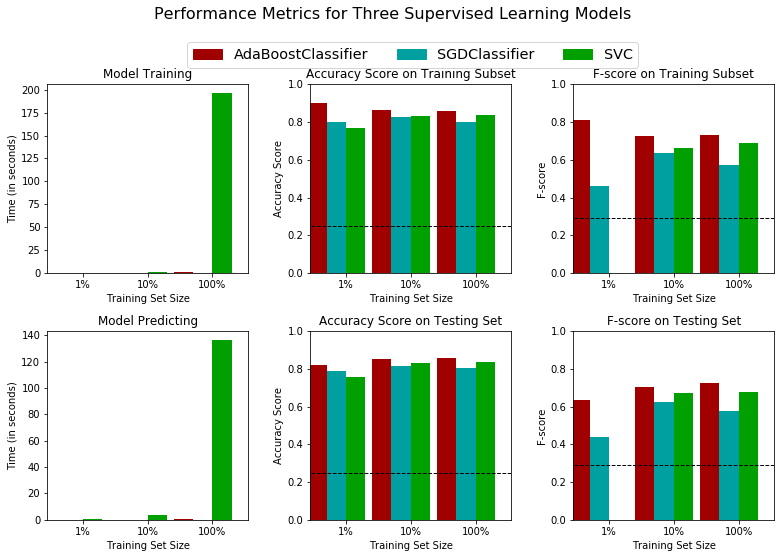

In [10]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

# TODO: Initialize the three models
clf_A = AdaBoostClassifier(random_state=42)
clf_B = SGDClassifier(loss ='perceptron',random_state = 42)
clf_C = SVC(random_state = 42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = int(len(y_train))
samples_10 = int(0.1 * len(y_train))
samples_1 = int(0.01 * len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

###  Choosing the Best Model

* Based on the evaluation we performed earlier, we will explain to *CharityML* which of the three models we believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 


**Answer: **
 * The above graph gives us a great intuition about the working of the three models that we chose namely, the perceptron classifier, the SVM classifier and the Adaboost classifier using the decision stump. As mentioned earlier the SVM classifier takes the maximum time when 100% of the training data is used.The green bar in the training and predicting time figure is manifolds greater than both the AdaBoost and the SGDC classifiers. Also if we look at the f-1 score for training and testing data when 100% of the dataset is used the AdaBoost and the SVM classifiers produce almost the same result. However if we take into consideration the training and prediction time we would definitely rule out the SVM classifier mainly due to the time is take for the algorithm to run and also owing to the fact that AdaBoost produces similar results. Also if we consider all the training and testing data sizes( 1%, 10% and 100%) the AdaBoost algorithm produces higher or almost the same f-1 scores as the SVM classifier and as a result of this I think that the AdaBoost classifier would be the best suited classifier for identifying individuals that make more than $50,000.
 
 * The above mentioned reasons also throw light to the fact that AdaBoost algorithm which gave us the highest f-1 scores on all sizes of dataset would be better at extracting the hidden attribute importances and therby would generalize well on the unseen data. Thus in conclusion AdaBoost is the best classifier that we can use in our urrent situation.
 

###  Describing the Model in Layman's Terms

* We will explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work.


**Answer: ** 

* The AdaBoost algorithm works by fitting a sequence of weak learners on data that is being modified at every iteration of those fittings of weak learners. At the end of the algorithm the predictions are made by combining all those weak models through a weighted sum. The process takes place as follows:

    - TRAINING: At the start of the training a weak decision tree classifier with depths as low as 1 is used to fit the data in such a way that minimum error is produced. After that all the correctly and incorrectly classified points are counted and the weights of the incorrectly classified points are modified in such a way that the total weight of correctly and incorrectly classified points become equal(This increase in weight is done to make sure that the next weak classifier classifies those incorrectly classified points perfectly when the fitting is done again.) The above mentioned process continues till there are no misclassified points or till maximum iteration is reached. Thus at the end of the training session we have a certain number of weak classifiers which we combine in the prediction step.
    
    - COMBINING THE MODELS: As mentioned in the training step above we created a certain number of weak classifiers. There is a weight associated with every such model. This weight can be any real number. For every such model the area classified as positive is given a positive value of the corresponding weight and the areas classified as negative are given negative value of the corresponding weight. After doing this all the models are combined and a weighted sum of all the regions is taken. In the end certain areas of the final model will have values of weights greater than zero and certain areas wile have values of weights less than zero.
    
    - PREDICTION: Finally any point that belongs to a positive area of the final model is classified as positive and any model belonging to the negative areas is classified as negative.
    
* Thus by using many weak models and combining them we made a complex model that can classify data points well enough than not only a Naive classifier but also better and more efficiently than non-linear classifiers like SVM.  

### Implementation: Model Tuning

In [11]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=42)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
learning_rate  = list(np.arange(0.5,2,0.2))



parameters = {'n_estimators': n_estimators,'learning_rate': learning_rate}


# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf,parameters,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8677
Final F-score on the testing data: 0.7457


###  Final Model Evaluation

* What is our optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from our optimized model compare to the naive predictor benchmarks we found earlier in ?


#### Results:

|     Metric     | Naive Model       |Unoptimized Model | Optimized Model |
| :------------: | :---------------: |:---------------: | :-------------: | 
| Accuracy Score |   0.2478          |   0.8576         |   0.8677        |
| F-score        |   0.2917          |   0.7246         |   0.7457        |


**Answer: **

* As seen from the table above the f1-scores of the optimized model are better than the unoptimized model. Also the naive model is no match for the optimized model. The f1-score is quite high than the naive model and that is due to the fact that in the naive model we predicted everyone to be the doner whereas in the optimized model we created complex decision boundaries on the basis of the features with the help of AdaBoost classifier which in turn helped us in predicting better on the unseen data.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

We will choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell we will fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

###  Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, the 5 features that we believe to be the most important for prediction are in the given order: 

**Answer:**
* The following are the top five features that I consider most important:
    
    - OCCUPATION(1)    : Occupation comes at the topmost of the list because the income of a person is directly related to what a person does and certain occupations like doctor, lawyers etc. tend to make more money than their counterparts. Also since we are targeting people with salaries greater than 50K the occupation of a person gives us good insights. For example(A person at managerial role will have salaries higher than a person who is in a clerical position) 
    
    - WORK_CLASS(2)    : Work class is another important feature which can give us good insights about a person's salary. For example. A person working for a private sector company is definitely going to earn more than a person who works for a local government. I have onsidered the second most important feature because whatever the occupation of a person is, his salary greatly depends on the work_class he works in.(For eg. A doctor in private hospital is going to earn more than a doctor in public hospital)
    
    - EDUCATION (3)    : Generally people who tend to have a good education also tend to make more money. A person with a Phd is definitely going to make more money than a high-school graduate. Thus education is an important feature in determining a person's salary. This feature is third in the list as I think its not always necessary that a person with good education is successful. We have good good examples of dropouts who have made it better than their graduate counter parts.
    
    - HOURS_PER_WEEK(4): The more a person works the more is his or hers' income and hece the number of hours a person works in  a week gives us a meaningful insight of his or her's salary. However this feature is fourth in the list because sometimes a person may be working 40 hours a week on minimum wages while on the other hand we may have a person working 20 hours part time with thrice the hourly minimum wage and in such a case the salary of the person working part-time is more than his full time counterpart. Hence the hours_per_week feature is subjective and it depends more on the occupation of the person.
    
    - CAPITAL_GAIN  (5): Capital gain indicates a profit from a sale of property or an investment. Thus we can reasonably say that higer the capital gain higher is the income of that person and he is more likely to make an investment. I have ranked this feature at the bottom of the list because I think that a person other than a reasl estate businessman is less likely to sell his property or investments and hence capital gain is not an event that occurs as usually as other events.

### Implementation - Extracting Feature Importance
* We will choose AdaBoostClassifier as it has a feature importance attribute available for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.


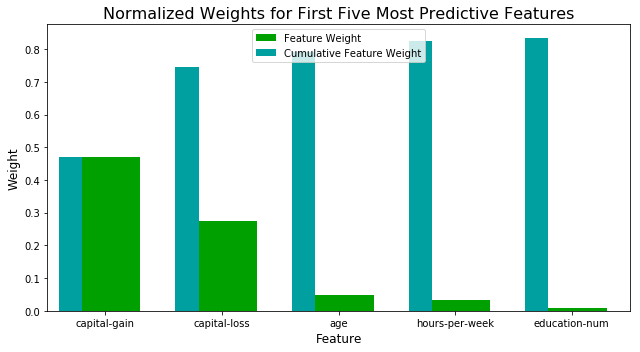

In [13]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set 
#AdaBoostClassifier(random_state=0)
model = AdaBoostClassifier(random_state=0,n_estimators=500).fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

###  Extracting Feature Importance

Observing the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000, we will try to answer the following questions.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

* The visualizations above are quite different than the ones predicted by me. My prediction was only partially right. Out of the five features predicted by me , 3 of them seem to pop up in the visualization above, though not in the same order.

* I was not that close to the answer as my prediction's order were far off from the order presented in the visualization.

* The reason I think I could not capture the truly important features is because I did not have a good insight of the data. Since the algorithm that I have performed above takes the insight of the data with mathematical manipulations, I think these machine learning algorithms better capture the true underlying importance of the individual features. Also as mentioned earlier I think capital-gain and capital-loss are events that do not occur often for a normal person and as a result they are given the least cumulative feature weight from the top five features selected. A younger person will definitely have lesser experience than a person who is older and we have seen in job market that people with more experience tend to make more money than people with less experience. After this no matter what the experience of the person, if a person with higher experience works less hours per week while a person with less experience works more hours, there are chances that a less experienced person will make more money than his counterpart and hence 'hours_per_week' has higher feature importance than 'age'. Finally the education number has highest cumulaive feature weight from the top five selected feature and it makes sense because a person with a higher education number will be highly qualified than person with lower education number and no matter how many hours per week he works or what his age is, he is qoing to make more money than his counterparts.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model we found earlier, and train it on the same training set *with only the top five important features*. 

In [14]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8677
F-score on testing data: 0.7457

Final Model trained on reduced data
------
Accuracy on testing data: 0.8421
F-score on testing data: 0.7017


###  Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

#### Results:

|     Metric     |Final Model(Full data) | Final Model(Reduced data) |
| :------------: |:---------------: | :-------------: | 
| Accuracy Score |   0.8677         |   0.8421        |
| F-score        |   0.7457         |   0.7017        |

* As we can see from the table above the accuracy of the final model with reduced data is almost 3% lesser than the model with full data whereas the F-score of reduced model is approximately 4% less than the F-score of model with full data. However the accuracy and f-score of the reduced data model is still very high as compared to the naive model. This reduction in model performance should not come as a shock, because what we are doing with reduced data model is removing or reducing information. Intuitively anything which has less information is always going to perform poorly than anything that has comparitivly more information. Thus no matter how less important the other features are, if we remove those features the model performance will be affected negatively to some level. 

* Feature removal should never be done when training the data does not take more time because removing information without any reason makes no sense. However in real world some datasets are huge and as we saw above there are certain algorithms like SVM which take a lot of time to train on large datasets and if we are working with real time applications we cannot afford such high training time, under such circumstances we should trade performance in favour of training time, however if the applications are life altering(For eg. Medical applications) then we should never compromise the performance of the model. Thus feature reduction is subjective and it depends highly on the application

In [3]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Untitled.ipynb to html',
 '[NbConvertApp] Writing 248821 bytes to Untitled.html',
 '[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 472983 bytes to finding_donors.html']